In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

In [5]:
# preview of dataset columns

df = pd.read_csv("Pantheon+SH0ES.dat", delim_whitespace=True, comment="#")
df.columns = df.columns.str.strip()
df[['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG']].head()

/var/folders/b6/wn089hyj689cjs24fp32pws00000gn/T/ipykernel_24557/3193030144.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("Pantheon+SH0ES.dat", delim_whitespace=True, comment="#")


,zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG
0,0.00122,28.9987,1.516450
1,0.00122,29.0559,1.517470
2,0.00256,30.7233,0.782372
3,0.00256,30.7449,0.799068
4,0.00299,30.7757,0.881212


In [6]:
df.columns

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')

In [7]:
# cleaning & extractinfg relevant data

df_clean = df.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG'])

z = df_clean['zHD'].values
mu = df_clean['MU_SH0ES'].values
mu_err = df_clean['MU_SH0ES_ERR_DIAG'].values

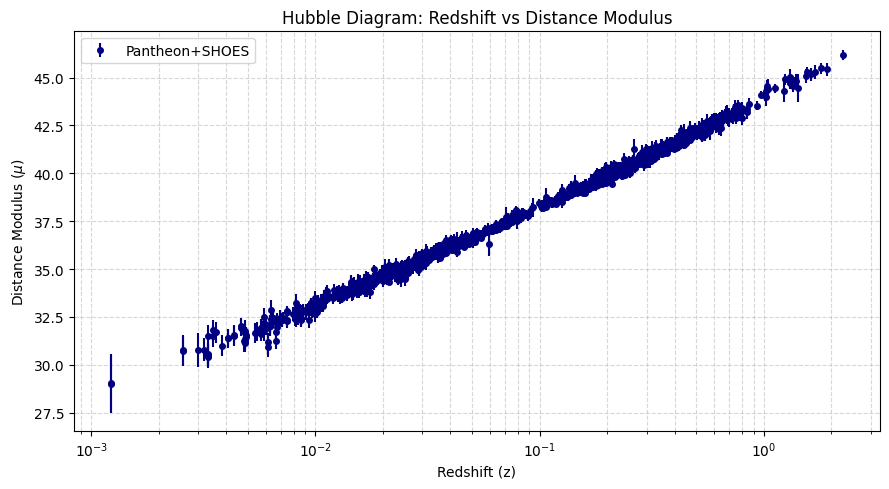

In [22]:
# plotting the hubble diagram
plt.figure(figsize=(9,5))
plt.errorbar(z, mu, yerr=mu_err, fmt='o', color='navy', markersize=4, label='Pantheon+SHOES')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\\mu$)')
plt.title('Hubble Diagram: Redshift vs Distance Modulus')
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Defining the Cosmological Model

We adopt the flat $\Lambda$CDM cosmological model as the theoretical framework. This involves the following key components:

- **Dimensionless Hubble Parameter:**

  $$
  E(z) = \sqrt{\Omega_m (1 + z)^3 + (1 - \Omega_m)}
  $$

  which encodes the redshift dependence of the expansion rate.

- **Luminosity Distance:**

  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

  representing the distance inferred from observed fluxes accounting for cosmic expansion.

- **Distance Modulus:**

  $$
  \mu(z) = 5 \log_{10}\left(\frac{d_L}{\mathrm{Mpc}}\right) + 25
  $$

  connecting observed magnitudes to luminosity distances.

These equations enable calculating the expected distance modulus $\mu(z)$ for any redshift $z$, given the Hubble constant $H_0$ and matter density parameter $\Omega_m$.



In [9]:
# SPEED OF LIGHT in km/s
c_kms = c.to('km/s').value

def E(z, Omega_m):
    """Dimensionless Hubble parameter."""
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def luminosity_distance(z, H0, Omega_m):
    """Luminosity distance in Mpc."""
    integral, _ = quad(lambda z_prime: 1.0 / E(z_prime, Omega_m), 0, z)
    return (1 + z) * (c_kms / H0) * integral

def mu_theory(z, H0, Omega_m):
    """Distance modulus for redshift z."""
    if isinstance(z, np.ndarray):
        return np.array([5 * np.log10(luminosity_distance(zi, H0, Omega_m)) + 25 for zi in z])
    else:
        return 5 * np.log10(luminosity_distance(z, H0, Omega_m)) + 25

# Fit the Model to Supernova Data

We perform a non-linear least squares fit to the supernova observations using the theoretical expression for $\mu(z)$. This procedure estimates the best-fit values of the Hubble constant ($H_0$) and the matter density parameter ($\Omega_m$), including uncertainties on each parameter.

Key steps and inputs:

- `curve_fit` from `scipy.optimize` is used to optimize the model parameters.
- The fit utilizes the observed distance modulus ($\mu$), redshift ($z$), and their measurement errors.

**Initial parameter guesses:**

- $H_0 = 70\,\mathrm{km/s/Mpc}$
- $\Omega_m = 0.3$


In [10]:
def fit_mu(z, H0, Omega_m):
    return mu_theory(z, H0, Omega_m)

# Initial guess for parameters
p0 = [70, 0.3]

# Perform curve fitting
popt, pcov = curve_fit(
    fit_mu,
    z,         # array of redshifts
    mu,        # observed distance modulus
    sigma=mu_err,  # observational errors
    absolute_sigma=True,
    p0=p0
)

# Extract fitted values and uncertainties
H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")

Fitted H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019



# Estimating the Age of the Universe

With the best-fit values for $H_0$ and $\Omega_m$ determined, we can estimate the **age of the universe**. This is accomplished by integrating the inverse of the Hubble parameter as a function of redshift:

$$
t_0 = \int_0^{\infty} \frac{1}{(1 + z) H(z)} \, dz
$$

The result is calculated using $H_0$ in SI units and reported in **gigayears (Gyr)**. This provides an independent consistency check for our cosmological model by comparing the estimated age to values obtained from other probes, such as Planck CMB measurements.


In [11]:
def age_of_universe(H0, Omega_m):
    integrand = lambda z: 1 / ((1 + z) * E(z, Omega_m))
    integral, _ = quad(integrand, 0, np.inf)
    H0_SI = (H0 * u.km / u.s / u.Mpc).to(1/u.s).value
    t_sec = integral / H0_SI
    return t_sec / (3600 * 24 * 365.25 * 1e9)  # Gyr

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Estimated age of Universe: 12.36 Gyr



# Analyzing Residuals

To assess the quality of our cosmological model fit, we compute the **residuals**:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

By plotting residuals as a function of redshift, we can reveal any systematic trends, biases, or outliers in the data.  
A well-fitting model should yield residuals that are randomly scattered around zero without significant structure, indicating consistency between the theory and observations.


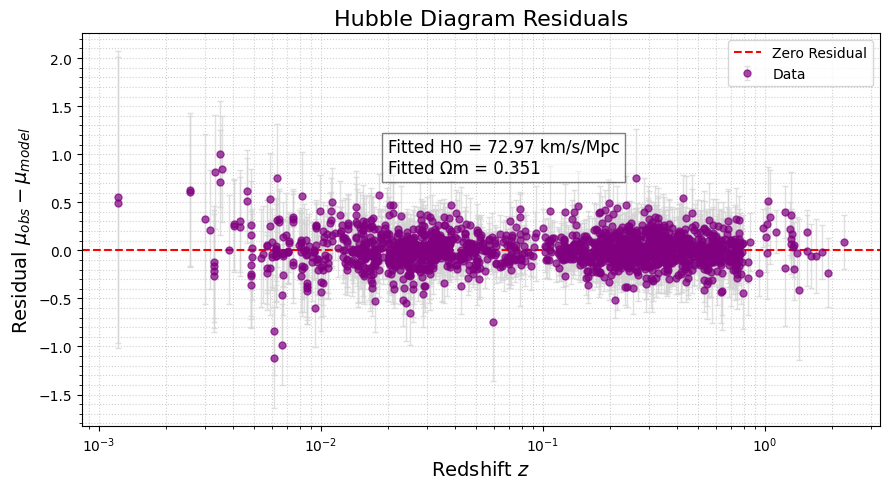

In [12]:
mu_model = mu_theory(z, H0_fit, Omega_m_fit)
residuals = mu - mu_model

plt.figure(figsize=(9, 5))

plt.errorbar(
    z, residuals, yerr=mu_err, fmt='o', markersize=5, 
    color='purple', ecolor='lightgray', elinewidth=1, capsize=2, alpha=0.7, label='Data'
)

plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual')

plt.xlabel("Redshift $z$", fontsize=14)
plt.ylabel("Residual $\\mu_{obs} - \\mu_{model}$", fontsize=14)
plt.title("Hubble Diagram Residuals", fontsize=16)

plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.xscale("log")
plt.minorticks_on()

plt.text(
    0.02, max(residuals)*0.8, 
    f"Fitted H0 = {H0_fit:.2f} km/s/Mpc\nFitted Ωm = {Omega_m_fit:.3f}", 
    fontsize=12, bbox=dict(facecolor='white', alpha=0.5)
)

plt.legend()
plt.tight_layout()
plt.show()

### Fitting the Distance Modulus with Fixed Matter Density

We define a fitting function `mu_fixed_Om` that assumes a fixed matter density parameter $\Omega_m = 0.3$ and fits only for the Hubble constant $H_0$.

- The initial guess for $H_0$ is set to 70 km/s/Mpc.
- We use `curve_fit` from `scipy.optimize` to fit the model to the observed distance modulus data, accounting for measurement uncertainties.
- The best-fit value of $H_0$ and its corresponding uncertainty are extracted from the covariance matrix.



In [13]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# initial guess for H0
p0 = [70]

# curve fitting
popt_fixed, pcov_fixed = curve_fit(
    mu_fixed_Om, z, mu,
    sigma=mu_err,
    absolute_sigma=True,
    p0=p0
)

# extract fitted H0 and its uncertainty
H0_fixed = popt_fixed[0]
H0_fixed_err = np.sqrt(np.diag(pcov_fixed))[0]

print(f"Fitted H0 with Ωm = 0.3: {H0_fixed:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")

Fitted H0 with Ωm = 0.3: 73.53 ± 0.17 km/s/Mpc



### Comparing Low-z and High-z Subsamples

We split the supernova dataset at a redshift threshold $z_{\text{split}} = 0.1$ to investigate potential differences in the inferred Hubble constant, $H_0$, at low and high redshifts.

- Create boolean masks to separate the data into:
  - **Low-z** subsample: $z < 0.1$
  - **High-z** subsample: $z \geq 0.1$

- Extract the redshift, distance modulus, and uncertainties for each subsample.

- Perform curve fitting independently on each subset, fixing the matter density parameter at $\Omega_m = 0.3$ and fitting for $H_0$.

- Print best-fit values of $H_0$ for each subsample.



In [14]:
# split redshift at z_split
z_split = 0.1
low_mask = z < z_split
high_mask = z >= z_split

# data for low-z and high-z
z_low, mu_low, mu_err_low = z[low_mask], mu[low_mask], mu_err[low_mask]
z_high, mu_high, mu_err_high = z[high_mask], mu[high_mask], mu_err[high_mask]

# fit H0 with fixed Omega_m = 0.3
H0_low, _ = curve_fit(mu_fixed_Om, z_low, mu_low, sigma=mu_err_low, absolute_sigma=True, p0=[70])
H0_high, _ = curve_fit(mu_fixed_Om, z_high, mu_high, sigma=mu_err_high, absolute_sigma=True, p0=[70])

print(f"Low-z (z < {z_split}): H0 = {H0_low[0]:.2f} km/s/Mpc")
print(f"High-z (z >= {z_split}): H0 = {H0_high[0]:.2f} km/s/Mpc")

Low-z (z < 0.1): H0 = 73.01 km/s/Mpc
High-z (z >= 0.1): H0 = 73.85 km/s/Mpc


### Hubble Diagram with Flat $\Lambda$ CDM Model Fit

This plot illustrates the relationship between supernova distance modulus and redshift, overlaid with the best-fit flat $\Lambda$CDM cosmological model:

- **Data points:** Pantheon+SH0ES supernovae with observational uncertainties (error bars).
- **Model curve:** Theoretical $\Lambda$CDM fit, using optimized values for $H_0$ and $\Omega_m$.
- The redshift axis is logarithmic to highlight both nearby and distant supernovae.
- The distance modulus $\mu$ traces the expansion history of the universe.



<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/var/folders/b6/wn089hyj689cjs24fp32pws00000gn/T/ipykernel_24557/3372345462.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Distance Modulus $\mu$")


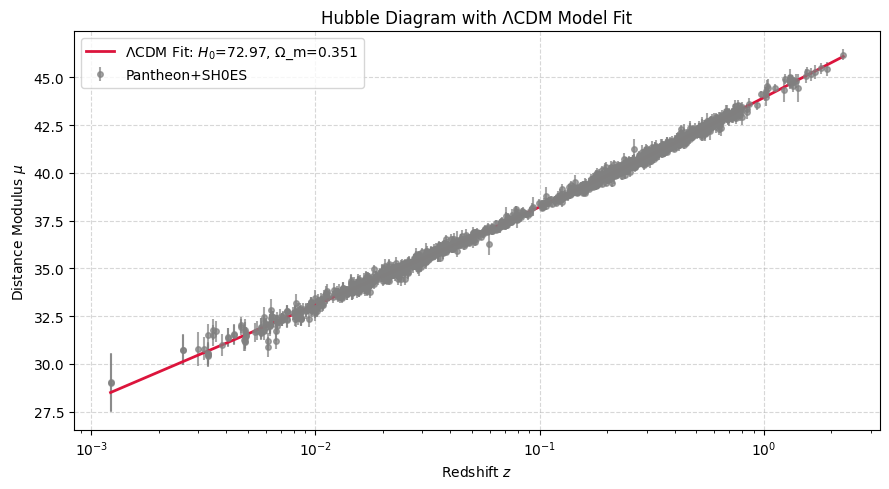

In [15]:
# hubble diagram w ΛCDM model fit
z_sorted = np.sort(z)
mu_model_sorted = mu_theory(z_sorted, H0_fit, Omega_m_fit)

plt.figure(figsize=(9, 5))

plt.errorbar(
    z, mu, yerr=mu_err, fmt='o', markersize=4, color='gray', label='Pantheon+SH0ES', alpha=0.7
)

plt.plot(
    z_sorted, mu_model_sorted, color='crimson', linewidth=2,
    label=f'ΛCDM Fit: $H_0$={H0_fit:.2f}, Ω_m={Omega_m_fit:.3f}'
)

plt.xscale("log")
plt.xlabel("Redshift $z$")
plt.ylabel("Distance Modulus $\mu$")
plt.title("Hubble Diagram with ΛCDM Model Fit")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Residuals vs Distance Modulus

This scatter plot visualizes the residuals between observed and model-predicted distance moduli:

- **X-axis:** Distance modulus ($\mu$) for each supernova.
- **Y-axis:** Residuals, defined as $\mu_{\text{obs}} - \mu_{\text{model}}$.
- The horizontal dashed red line at zero highlights where residuals should cluster if the model fits well.
- Random scatter around zero indicates a good fit without systematic bias.



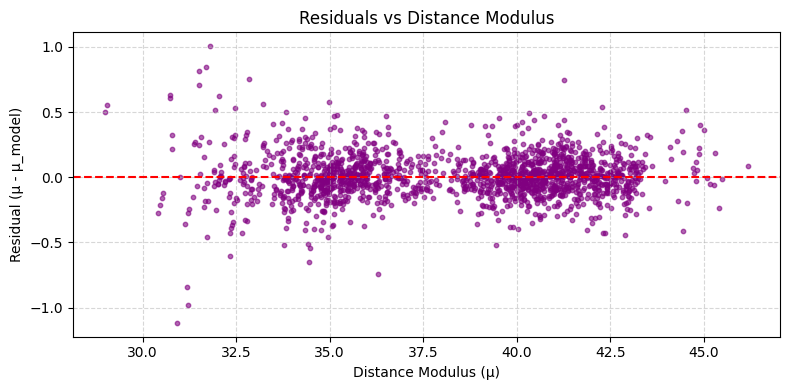

In [16]:
# RESIDUALS VS DISTANCE MODULUS
plt.figure(figsize=(8, 4))
plt.scatter(mu, residuals, s=10, color='purple', alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Distance Modulus (μ)")
plt.ylabel("Residual (μ - μ_model)")
plt.title("Residuals vs Distance Modulus")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Histogram of Residuals

This histogram displays the distribution of residuals between observed and model-predicted distance moduli for supernovae:

- **X-axis:** Residual ($\mu_{\text{obs}} - \mu_{\text{model}}$)
- **Y-axis:** Number of supernovae in each residual bin
- The red dashed vertical line at zero marks where the residuals should center for a well-fit model.
- A symmetrical, centered distribution indicates the model accurately represents the data.



<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/b6/wn089hyj689cjs24fp32pws00000gn/T/ipykernel_24557/3059709573.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Residual ($\mu_{obs} - \mu_{model}$)")


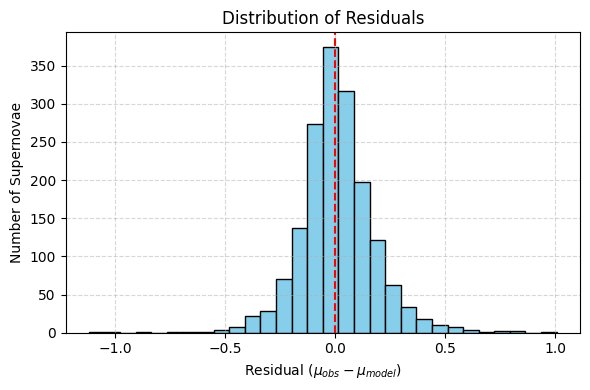

In [17]:
# HISTOGRAM OF RESIDUALS
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual ($\mu_{obs} - \mu_{model}$)")
plt.ylabel("Number of Supernovae")
plt.title("Distribution of Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Hubble Diagram: Low-z vs High-z Fit Comparison

This plot compares the observed supernova distance moduli to two separate $\Lambda$CDM fits:

- **Data points:** Observed supernovae with error bars ($\mu$ vs. $z$).
- **Sky blue dashed line:** Fit to the low-redshift ($z < 0.1$) subsample, using its best-fit $H_0$.
- **Orange dotted line:** Fit to the high-redshift ($z \geq 0.1$) subsample, using its best-fit $H_0$.
- The redshift axis is shown on a logarithmic scale.

This visualization helps identify any tension, trend, or discrepancy between $H_0$ values inferred from low-$z$ and high-$z$ data.



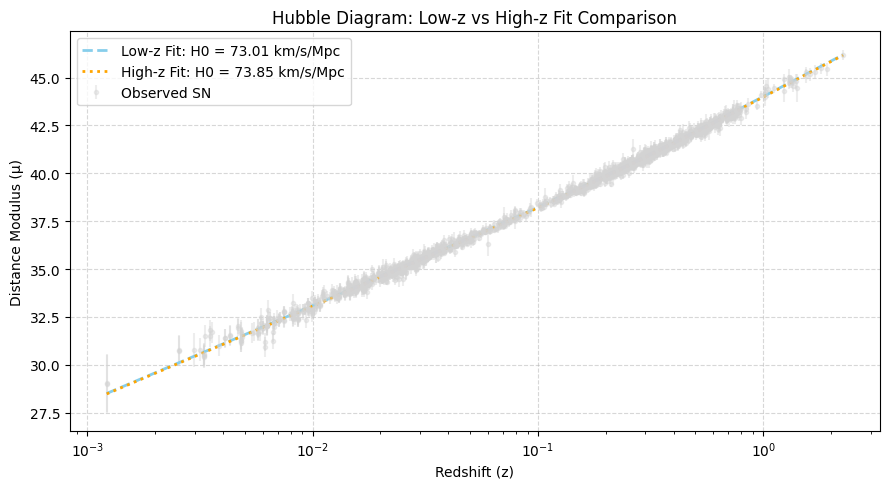

In [18]:
# LOW-Z VS HIGH-Z
z_sorted = np.sort(z)
mu_low = mu_theory(z_sorted, H0_low[0], 0.3)
mu_high = mu_theory(z_sorted, H0_high[0], 0.3)

plt.figure(figsize=(9, 5))

plt.errorbar(
    z, mu, yerr=mu_err, fmt='o', markersize=3, color='lightgray', alpha=0.4, label="Observed SN"
)

# low-z fit
plt.plot(
    z_sorted, mu_low, '--', color='skyblue', linewidth=2,
    label=f'Low-z Fit: H0 = {H0_low[0]:.2f} km/s/Mpc'
)

# high-z fit
plt.plot(
    z_sorted, mu_high, ':', color='orange', linewidth=2,
    label=f'High-z Fit: H0 = {H0_high[0]:.2f} km/s/Mpc'
)

plt.xscale('log')
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
plt.title("Hubble Diagram: Low-z vs High-z Fit Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Parameter Uncertainty Visualization: Hubble Constant and Matter Density

We assess the joint uncertainties in the fitted cosmological parameters ($H_0$ and $\Omega_m$) by:

- Drawing 5,000 random samples from the multivariate normal distribution defined by the best-fit values and covariance matrix.
- Visualizing these samples using a **corner plot**, which shows the marginalized distributions and covariance between $H_0$ and $\Omega_m$.

The corner plot displays:
- Marginal probability distributions for each parameter,
- Central values and 68% credible intervals (quantiles),
- Parameter correlation structure.



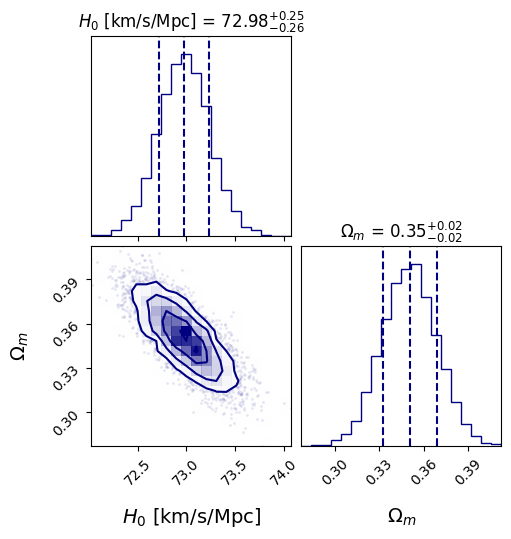

In [19]:
import corner
samples = np.random.multivariate_normal([H0_fit, Omega_m_fit], pcov, size=5000)

figure = corner.corner(
    samples,
    labels=["$H_0$ [km/s/Mpc]", "$\\Omega_m$"],
    show_titles=True,
    title_fmt=".2f",
    quantiles=[0.16, 0.5, 0.84], 
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    color='navy'
)